# Point Cloud-to-Simplicial Complex Lifting Tutorial
This notebook shows how to construct a simplicial complex from a point cloud using **Delaunay lifting**. This lifting constructs a simplicial complex from a point cloud using Delaunay triangulation.

In [1]:
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import PointCloudLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_transform_config,
)

In [13]:
loader = PointCloudLoader(
    {
        "data_dir": "modules/transforms/liftings/pointcloud2simplicial/",
    }
)

dataset = loader.load()

In [22]:
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "pointcloud2simplicial/delaunay_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for pointcloud2simplicial/delaunay_lifting:

{'transform_type': 'lifting',
 'transform_name': 'DelaunayLifting',
 'feature_lifting': 'ProjectionSum'}


Processing...
Done!


Simplicial Complex with shape (18, 44, 27) and dimension 2
{'incidence_0': tensor(indices=tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                         0,  0,  0,  0],
                       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
                        14, 15, 16, 17]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1.]),
       size=(1, 18), nnz=18, layout=torch.sparse_coo), 'down_laplacian_0': tensor(indices=tensor([], size=(2, 0)),
       values=tensor([], size=(0,)),
       size=(18, 18), nnz=0, layout=torch.sparse_coo), 'up_laplacian_0': tensor(indices=tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,
                         2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,
                         5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
                         7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10,
                  

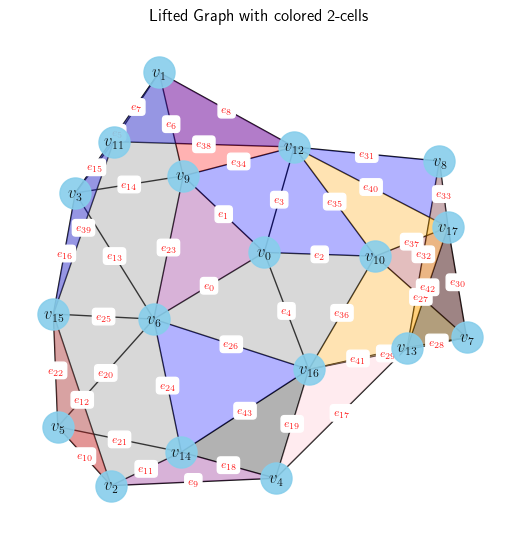

 - The complex has 18 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 44 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 27 2-cells.
 - The 2-cells have features dimension 1



In [25]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)